## Titanic - ML1 lesson 2 
### 18th March 2018


## Random Forest Model Interpretation

In [202]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics



In [204]:
set_plot_sizes(12, 14, 16)

## Load in our data from last session


In [205]:
PATH = "data/titanic/"
df_raw = pd.read_feather(f'{PATH}titanic_raw')
df, y, nas = proc_df(df_raw, 'Survived')

In [206]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

# n_valid = 418 #same as Kaggle's test set size
n_valid = 100 #smaller validation set to provide more training data
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
x_train, x_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

raw_train.shape, x_train.shape, y_train.shape, x_valid.shape, y_valid.shape


((791, 12), (791, 12), (791,), (100, 12), (100,))

In [207]:
df_raw.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,None,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,None,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,None,Q


## functions

In [208]:
def rmse(pred,actual): return math.sqrt(((pred-actual)**2).mean())

In [209]:
def print_score(m):
    result = [f'rmse train: {rmse(m.predict(x_train), y_train)} Training set size: {len(y_train)}', 
              f'\nrmse validation: {rmse(m.predict(x_valid), y_valid)} Validation set size: {len(y_valid)}',
              f'\nRsquared train: {m.score(x_train, y_train)}',
              f'\nRSquared valid: {m.score(x_valid, y_valid)}']
    print(result[0], result[1], result[2], result[3])
    if hasattr(m, 'oob_score_'):
        result.append(f'OOB: {m.oob_score_}')
        print(result[4])

In [210]:
def custom_print_score(m, x_t, y_t):
    result = [f'rmse train: {rmse(m.predict(x_t), y_t)} Total set size: {len(y_t)}', 
              f'\nRsquared train: {m.score(x_t, y_t)}']
    print(result[0], result[1])
    if hasattr(m, 'oob_score_'):
        result.append(f'OOB: {m.oob_score_}')
        print(result[2])

In [211]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, 
                           "display.max_columns", 1000):
        display(df)

## Confidence based on tree variance
For model interpretation, there's no need to use the full dataset on each tree - using a subset will be faster, and also provide better interpretability, since an overfit model will not provide much variance across trees.

In [212]:
# set_rf_samples(1000)
reset_rf_samples()

In [213]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

rmse train: 0.22899786465703273 Training set size: 791 
rmse validation: 0.3244111372167042 Validation set size: 100 
Rsquared train: 0.778918365231997 
RSquared valid: 0.543217942924326
OOB: 0.4557975892517083


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of this estimate? One way is to use the standard deviation of predictions, instead of just the mean. This tells us the <em>relative</em> confidence of predictions  - that is , for rows where the trees give very different results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [214]:
passenger=4
%time preds = np.stack([t.predict(x_valid) for t in m.estimators_])
np.mean(preds[:,passenger]), np.std(preds[:, passenger])

CPU times: user 165 ms, sys: 304 µs, total: 165 ms
Wall time: 160 ms


(0.0475, 0.17027551203857824)

In [215]:
preds.shape # 40 averaged trees, for 418 passengers in the validation set

(40, 100)

In [216]:
preds.shape



(40, 100)

We are looking at the average of 40 trees' predictions for a single passenger's survival chances. 

When we use python to loop through trees in a list comprehension, we are calculating each tree in series, which is slow! We can use parallel processing to speed things up:


In [217]:
passenger=passenger
def get_preds(t): return t.predict(x_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,passenger]), np.std(preds[:,passenger])

CPU times: user 94.3 ms, sys: 158 ms, total: 252 ms
Wall time: 313 ms


(0.0475, 0.17027551203857824)

It is possible that splitting the job into parts for parallel processing takes more time than just running the operation in series for a small dataset. 

We can see that different trees give different estimates in this model - in order to see how prediction confidence varies, we can add this into our dataset: 

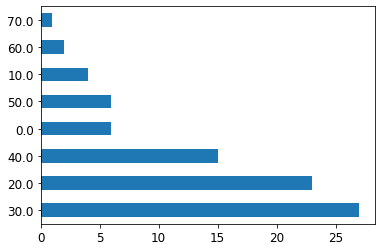

In [218]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Age.round(-1).value_counts().plot.barh()

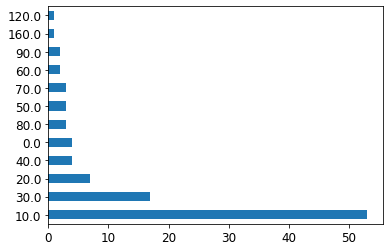

In [219]:
x.Fare.round(-1).value_counts().plot.barh()

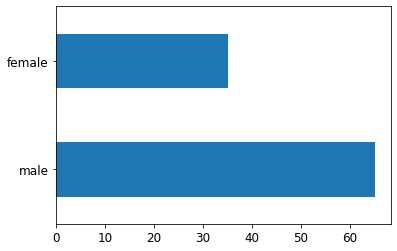

In [220]:
x.Sex.value_counts().plot.barh()

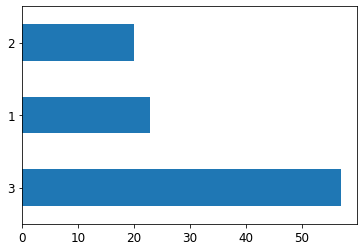

In [221]:
x.Pclass.value_counts().plot.barh()

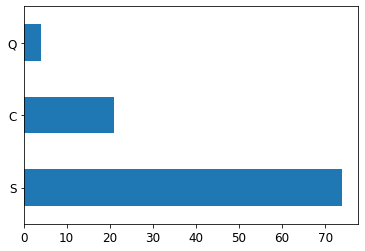

In [222]:
x.Embarked.value_counts().plot.barh()

In [223]:

fields = ['Sex', 'Survived', 'pred', 'pred_std']
sex_summ = x[fields].groupby('Sex', as_index=False).mean()
display_all(sex_summ)

,Sex,Survived,pred,pred_std
0,female,0.685714,0.693697,0.262054
1,male,0.184615,0.169350,0.215355


Standard deviations for sex as a predictor of survival are 0.26F and 0.29M for female and male when used on the split sample validation set of 418 passengers. If we use a smaller validation set and larger training set 791 train 100 valid, the standard deviation improves and we have 0.24F and 0.27M, still not huge but its an improvement. 

In [224]:
x_train.shape


(791, 12)

In [225]:


##enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
##enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

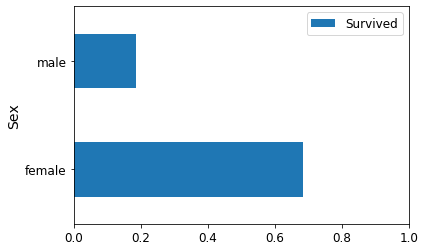

In [226]:
sex_summ.plot('Sex', 'Survived', 'barh', xlim=(0,1))

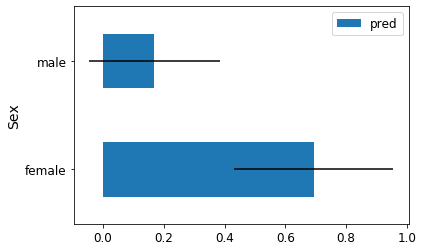

In [227]:
sex_summ.plot('Sex', 'pred', 'barh', xerr=('pred_std'))

maleness or femaleness isn't a good predictor using this model - we could try to train the model with a different set of samples and use the out of bag score for more accuracy. 

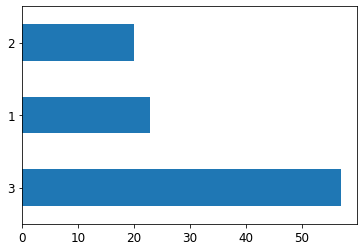

In [228]:
raw_valid.Pclass.value_counts().plot.barh()


In [229]:
flds = ['Pclass', 'Survived', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,Survived,pred,pred_std
Pclass,,,
1,0.739130,0.677747,0.246121
2,0.350000,0.397007,0.236906
3,0.210526,0.206295,0.224054


The predictions are nearly exactly right, but the error bars are quite wide. Why is this?

In [230]:
(summ.pred_std/summ.pred).sort_values(ascending=True)

Pclass
1    0.363146
2    0.596730
3    1.086082
dtype: float64

##  Feature Importance
It's not normally enough just to know that a model can make accurate predictions - we also want to know how its making the predictions. The most important way to see this is with feature importance. 

In [231]:
feature_importance = rf_feat_importance(m, df);
feature_importance[:10]

,cols,imp
3,Sex,0.348096
7,Ticket,0.115925
8,Fare,0.100884
4,Age,0.086925
2,Name,0.084737
0,PassengerId,0.081259
1,Pclass,0.070967
9,Cabin,0.059956
5,SibSp,0.022228
10,Embarked,0.015046


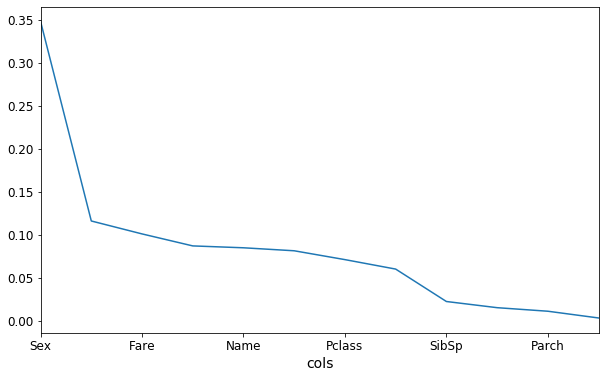

In [232]:
feature_importance.plot('cols', 'imp', figsize=(10,6), legend=False);

In [233]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [234]:
print(df['Age_na'].sum())
df.head(20)


177


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
0,1,3,109,2,22.0,1,0,524,7.2500,0,3,False
1,2,1,191,1,38.0,1,0,597,71.2833,82,1,False
2,3,3,354,1,26.0,0,0,670,7.9250,0,3,False
3,4,1,273,1,35.0,1,0,50,53.1000,56,3,False
4,5,3,16,2,35.0,0,0,473,8.0500,0,3,False
5,6,3,555,2,28.0,0,0,276,8.4583,0,2,True
6,7,1,516,2,54.0,0,0,86,51.8625,130,3,False
7,8,3,625,2,2.0,3,1,396,21.0750,0,3,False
8,9,3,413,1,27.0,0,2,345,11.1333,0,3,False
9,10,2,577,1,14.0,1,0,133,30.0708,0,1,False


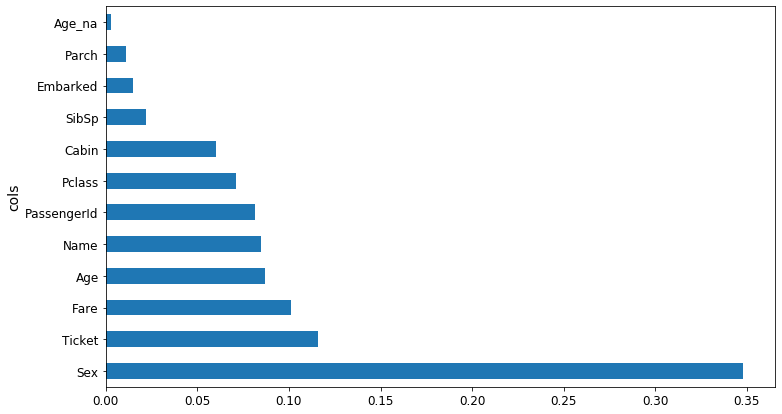

In [235]:
plot_fi(feature_importance)

It is clear that gender is the most important predictor of survival, but what about the other variables? The independent variables PassengerId, Fare, Age, Name and Ticket all seem to have some contribution, but why? One would expect the age to come into play but not necessarily the name. We can remove the least important contributors to try to reduce noise, provide more splitting opportunities and to reduce colinearity. 

In [236]:
to_keep = feature_importance[feature_importance.imp>0.05].cols;
to_keep

3            Sex
7         Ticket
8           Fare
4            Age
2           Name
0    PassengerId
1         Pclass
9          Cabin
Name: cols, dtype: object

In [237]:
# m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
#                           n_jobs=-1, oob_score=True)
# m.fit(X_train, y_train)
# print_score(m)

In [238]:
df_keep = df[to_keep].copy()
m=RandomForestRegressor(n_estimators=400, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(df_keep, y)
custom_print_score(m, df_keep, y)

rmse train: 0.2257697818606968 Total set size: 891 
Rsquared train: 0.784479500807428
OOB: 0.47907237815605574


In [239]:
df_keep.shape

(891, 8)

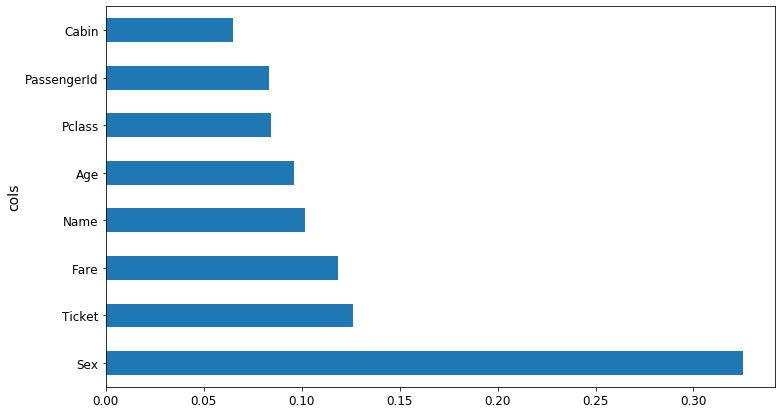

In [240]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)

## One_hot encoding
proc_df's optional max_n_cat argument will turn some categorical variables into new columns. 

For example, the column <b>Pclass</b> which has 3 categories, <b>1, 2, 3</b>

gets turned into 3 new  categories <b>Pclass_1, Pclass_2, Pclass_3 </b>

and the column Pclass gets removed. 

This could be useful when a single category has much more importance than the others - it would be instantly accessible by the decision tree, and would not waste valuable splits trying to identify the valuable category. 

It will only happen for columns whose number of categories is no bigger than the value of
<b>max_n_cat</b> argument

now some of these columns may prove to have more important features than in the earlier situation where all the categories were in one column.

In [241]:
train_cats(df_raw)


df_2, y, nas = proc_df(df_raw, 'Survived', max_n_cat=6)


In [242]:
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(df_2, y)
custom_print_score(m, df_2, y)

rmse train: 0.22412097047922816 Total set size: 891 
Rsquared train: 0.7876159264826535
OOB: 0.4761537707986553


In [243]:
df_raw.tail()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [244]:
df_2.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_na,Sex_female,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,3,109,22.0,1,0,524,7.2500,0,False,0,1,0,0,0,1,0
1,2,1,191,38.0,1,0,597,71.2833,82,False,1,0,0,1,0,0,0
2,3,3,354,26.0,0,0,670,7.9250,0,False,1,0,0,0,0,1,0
3,4,1,273,35.0,1,0,50,53.1000,56,False,1,0,0,0,0,1,0
4,5,3,16,35.0,0,0,473,8.0500,0,False,0,1,0,0,0,1,0


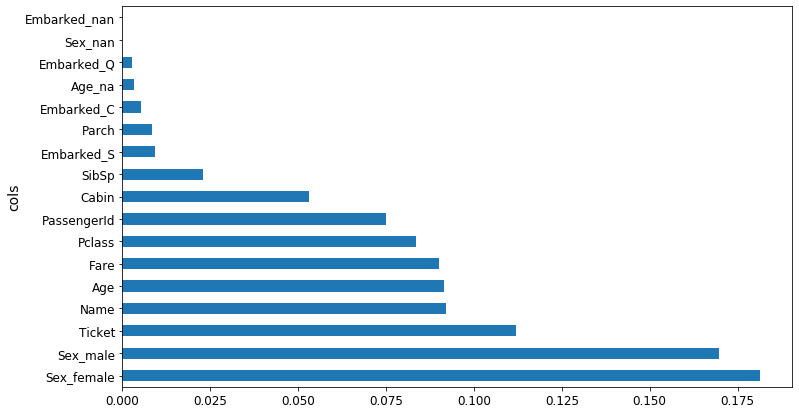

In [245]:
fi = rf_feat_importance(m, df_2)
plot_fi(fi)

## Removing redundant features
one thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Lets try to remove some redundant features.

In [246]:
from scipy.cluster import hierarchy as hc

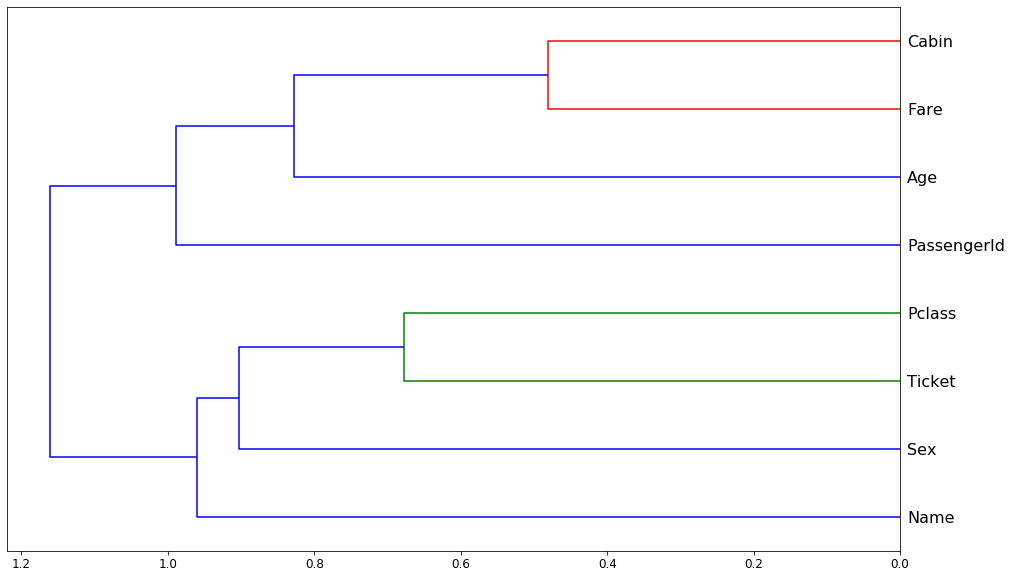

In [247]:
correlation = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-correlation)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 10))
dendogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

<b>There's a correlation between class and ticket price.</b> This makes sense - higher social class will afford higher ticket prices. We can see whether removing one of these variables improves the RSquared of our model


In [248]:
# def get_oob(df):
#     m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
#     x, _ = split_vals(df, n_trn)
#     m.fit(x, y_train)
#     return m.oob_score_

## Modified to use entire dataset since the dataset is small. 

def get_oob(df):
    m = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
    m.fit(df, y) # training the model on the entire set of samples
    return m.oob_score_
    
    
    
    

In [249]:
get_oob(df_keep)

0.4775027269938231

<b>0.47 is our baseline</b>
Now we try removing each variable one at a time

In [250]:
df['PassengerId']

0        1
1        2
2        3
3        4
4        5
      ... 
886    887
887    888
888    889
889    890
890    891
Name: PassengerId, Length: 891, dtype: int64

In [251]:
for c in to_keep:
    print(c, get_oob(df_keep.drop(c, axis=1)))

Sex 0.23906597479639058
Ticket 0.4575828276088929
Fare 0.46134760706950395
Age 0.4415183804745566
Name 0.46050389823806737
PassengerId 0.4823719833400191
Pclass 0.4403117677940924
Cabin 0.4774556663213019


It looks like removing the passenger ID column improves the RSquared significantly - this could be becuse PassengerId is correlated with another independent variable. 

Removing the Sex column reduces the predictivity of the model significantly - if we were to do any data cleaning we should focus our efforts there. 

In [252]:
to_drop = 'PassengerId'

In [253]:
get_oob(df_keep.drop(to_drop, axis=1))

0.4821629782236476

This is an improvement  - out of bag RSquared score of 0.48 by dropping PassengerId. let's use this dataframe from here.

In [254]:
df_keep.drop(to_drop, axis=1, inplace=True)


Since we have removed passenger id, we will need to remember to add the column to the output when submitting our results. 
<br>
<b>Passenger id = row number plus 1</b> 

In [255]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [256]:
keep_cols = np.load('tmp/keep_cols.npy')

In [257]:
keep_cols

array(['Sex', 'Ticket', 'Fare', 'Age', 'Name', 'Pclass', 'Cabin'], dtype=object)

In [258]:
df_keep = df[keep_cols]

In [259]:
df_keep

,Sex,Ticket,Fare,Age,Name,Pclass,Cabin
0,2,524,7.2500,22.0,109,3,0
1,1,597,71.2833,38.0,191,1,82
2,1,670,7.9250,26.0,354,3,0
3,1,50,53.1000,35.0,273,1,56
4,2,473,8.0500,35.0,16,3,0
...,...,...,...,...,...,...,...
886,2,102,13.0000,27.0,549,2,0
887,1,15,30.0000,19.0,304,1,31
888,1,676,23.4500,28.0,414,3,0
889,2,9,30.0000,26.0,82,1,61


Having worked out the important features on a subset of the samples, we could now use this reduced set of features on the entire dataset

In [260]:
reset_rf_samples()

In [261]:
m = RandomForestRegressor(n_estimators = 400, min_samples_leaf = 2, max_features = 0.5, n_jobs=-1, oob_score=True)
m.fit(df,y)
custom_print_score(m, df, y)

rmse train: 0.19090133932821748 Total set size: 891 
Rsquared train: 0.8459098392480723
OOB: 0.4785831724603846


## Partial Dependence

In [262]:
from pdpbox import pdp
from plotnine import *

In [263]:
set_rf_samples(50000)

This next analysis will be a little easier if we open up the 1 hot encoded categorical variables, so let's load them up again:

In [264]:
df2, y2, nas = proc_df(df_raw, 'Survived', max_n_cat = 6)
x_train, x_valid = split_vals(df2, n_trn) # use this on large datasets
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=2, max_features=0.5, n_jobs=-1)
m.fit(df2,y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

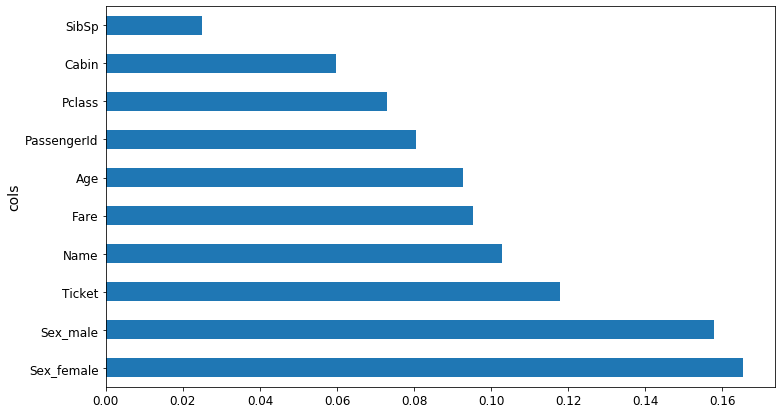

In [265]:
plot_fi(rf_feat_importance(m, df2)[:10])

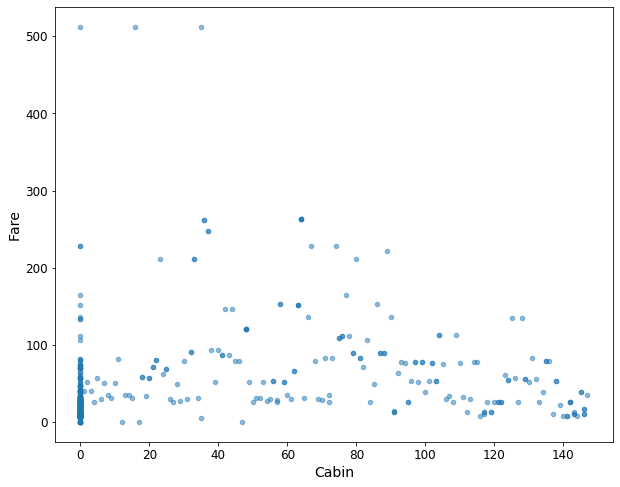

In [266]:
df2.plot('Cabin', 'Fare', 'scatter', alpha = 0.5, figsize = (10,8));

lots of the cabin fields were blank.

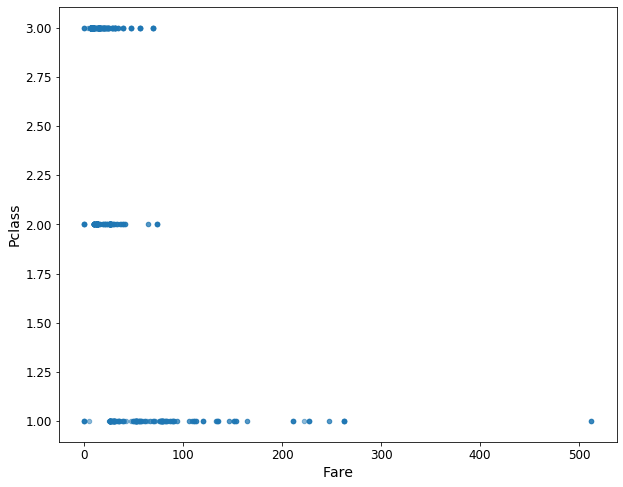

In [267]:
df2.plot('Fare', 'Pclass', 'scatter', alpha = 0.5, figsize = (10,8))

The higher fares were all paid by 1st class passengers. 

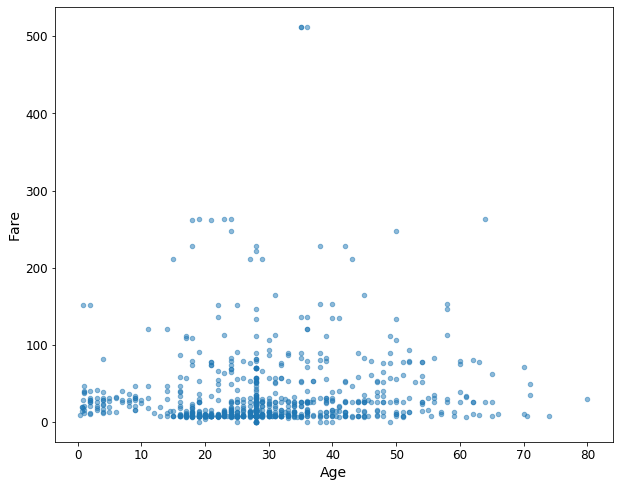

In [268]:
df2.plot('Age', 'Fare', 'scatter', alpha = 0.5, figsize = (10,8))

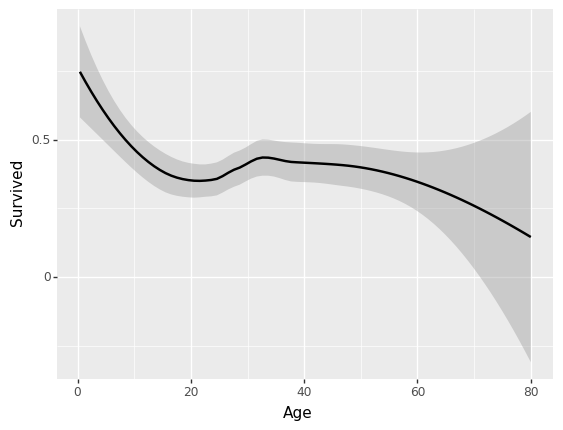

<ggplot: (8747776243548)>

In [269]:
ggplot(df_raw, aes('Age','Survived'))+stat_smooth(se=True, method='loess')

The chance of survival is higher for younger people and lower for older people, but the confidence drops for ages above 60 since there were only a few passengers over 60 included in the data. The median age was 28.

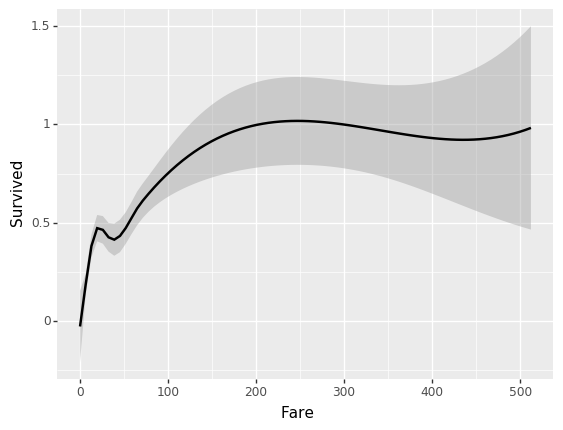

<ggplot: (-9223363289078536623)>

In [270]:
ggplot(df_raw, aes('Fare','Survived'))+stat_smooth(se=True, method='loess')

In [285]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, df_2, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, center=False, cluster=clusters is not None, n_cluster_centers=clusters)

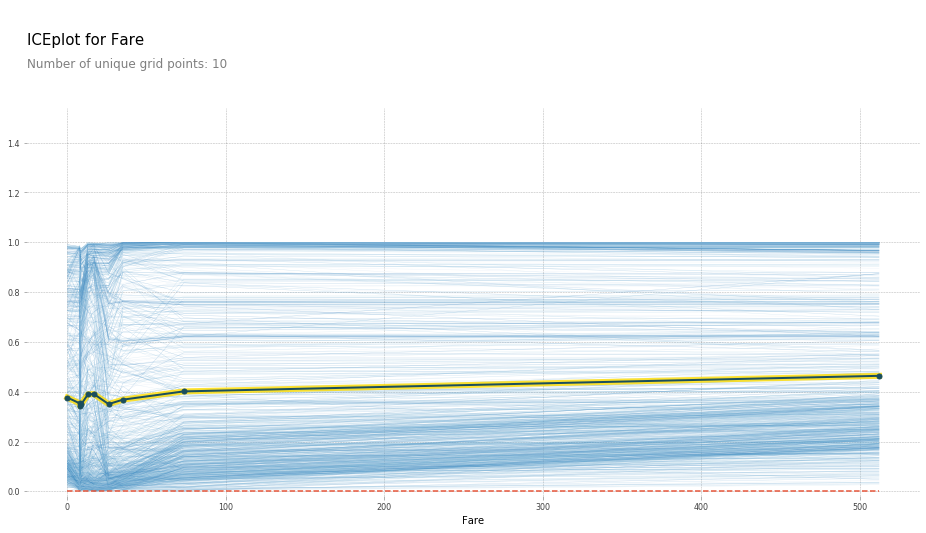

In [286]:
plot_pdp('Fare')

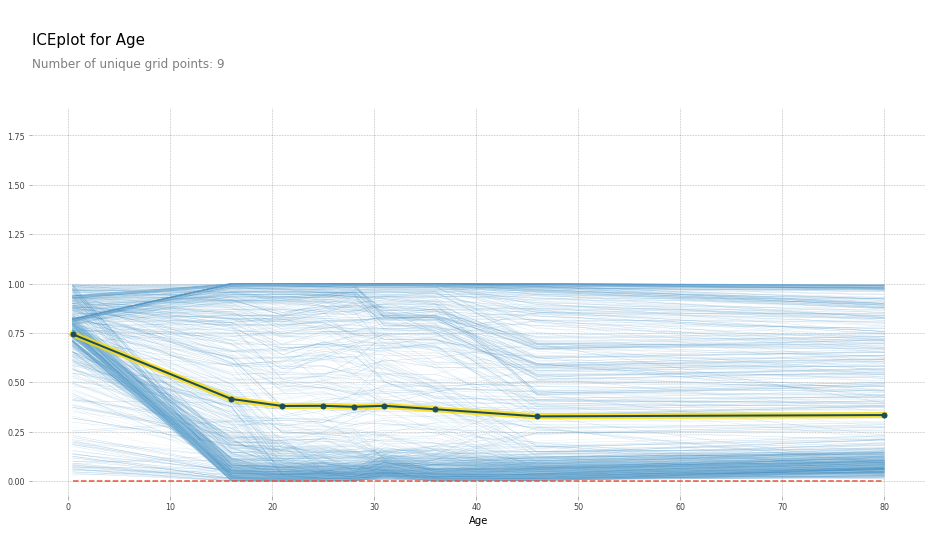

In [287]:
plot_pdp('Age')

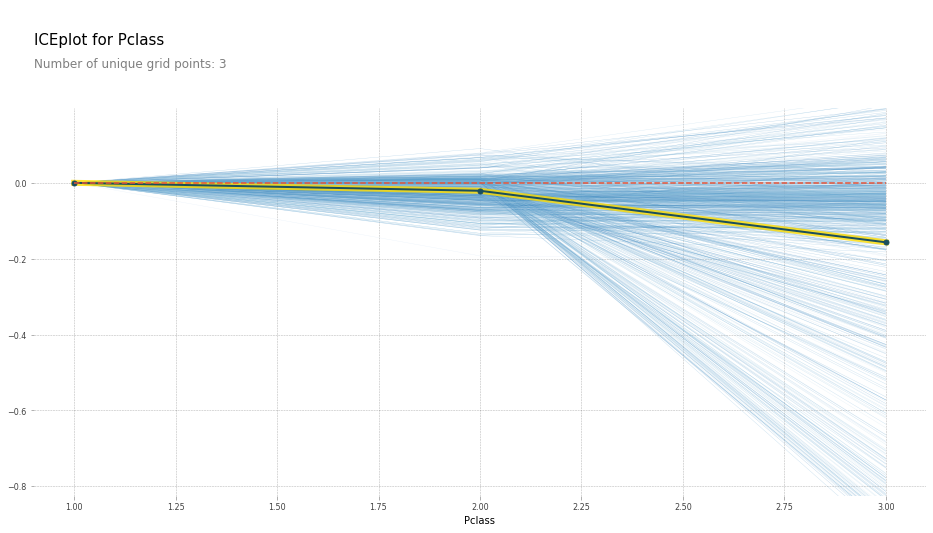

In [281]:
plot_pdp('Pclass')

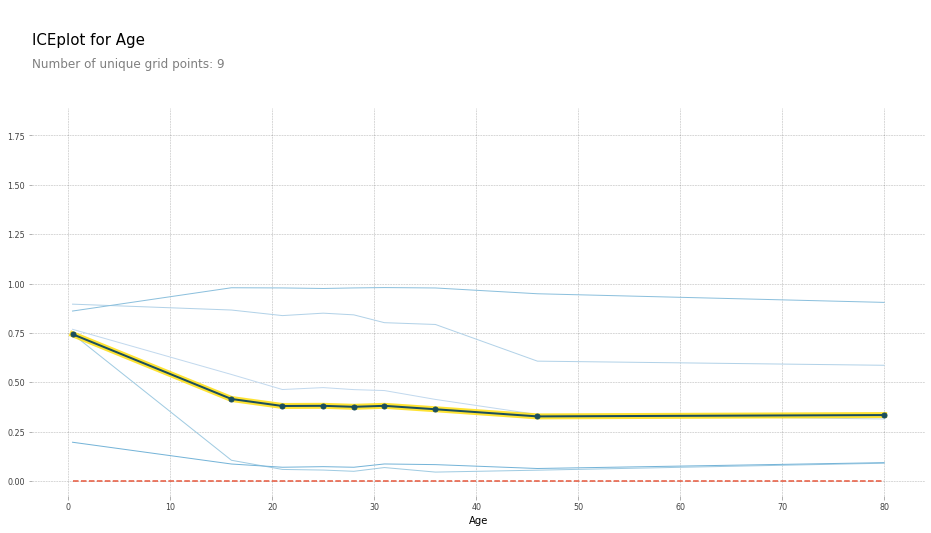

In [289]:
plot_pdp('Age', clusters=5)

In [291]:
feats=['Fare', 'Pclass']
p=pdp.pdp_interact(m,df_2,feats)


TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


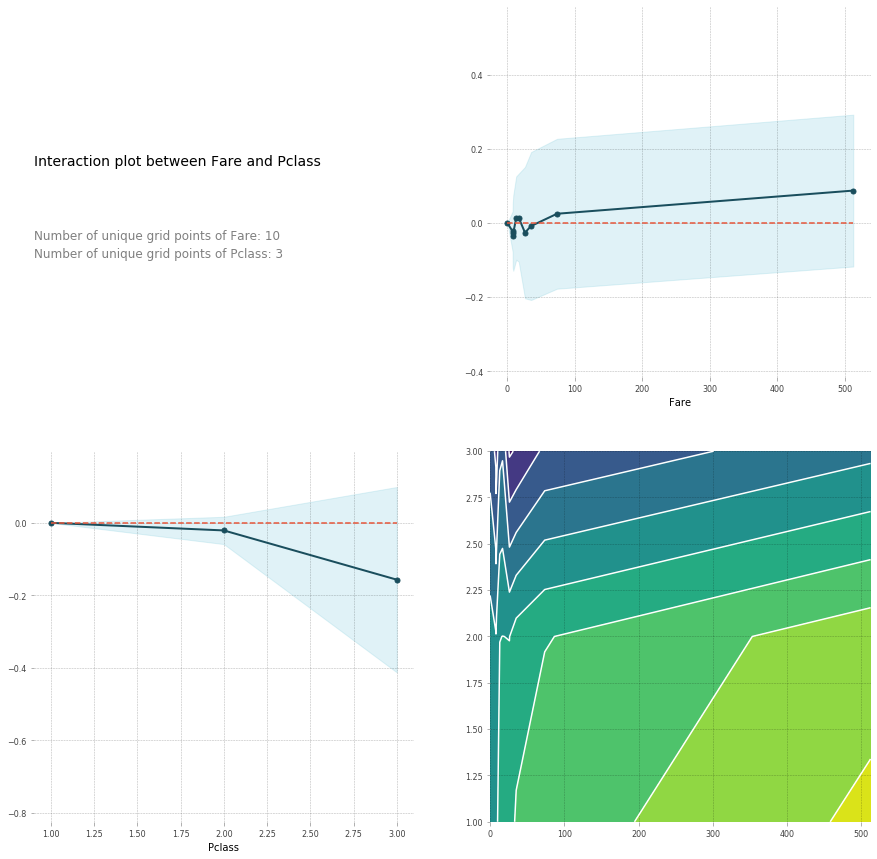

In [292]:
pdp.pdp_interact_plot(p, feats)